# 图像风格迁移



图像的风格迁移是卷积神经网络有趣的应用之一。那什么是风格迁移呢？下图第一列左边的图为相机拍摄的一张普通图片，右边的图为梵高的名画星空。那如何让左边的普通图片拥有星空的风格呢。神经网络的风格迁移就可以帮助你生成第二列的这样的图片。

<div align=center>
 <img src="images/markdown/img1.png" width = "600" height = "300"  />
</br>
 <img src="images/markdown/img2.png" width = "300" height = "300"  divalign=center />

In [1]:
%matplotlib inline

import os
import cv2
import copy
import argparse
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import paddle
from paddle.vision.models import vgg16
from paddle.vision.transforms import transforms

## 基本原理
风格迁移的目标就是使得生成图片的内容与内容图片（content image）尽可能相似。由于在计算机中，我们用一个一个像素点表示图片，所以两个图片的相似程度我们可以用每个像素点的欧式距离来表示。而两个图片的风格相似度，我们采用两个图片在卷积神经网络中相同的一层特征图的gram矩阵的欧式距离来表示。对于一个特征图gram矩阵的计算如下所示：

```python
# tensor shape is [1, c, h, w]
_, c, h, w = tensor.shape
tensor = paddle.reshape(tensor, [c, h * w])
# gram matrix with shape: [c, c]
gram_matrix = paddle.matmul(tensor, paddle.transpose(tensor, [1, 0]))
```

最终风格迁移的问题转化为优化上述的两个欧式距离的问题。这里要注意的是，我们使用一个在imagenet上预训练好的模型vgg16，并且固定参数，优化器只更新输入的生成图像的值。

## 具体实现
接下来，使用代码一步一步来实现上述图片的风格迁移

In [2]:
# 载入图像并进行预处理
def load_image(image_path, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')
    size = shape if shape is not None else max_size if max(
        image.size) > max_size else max(image.size)

    transform = transforms.Compose([
        transforms.Resize(size), transforms.Transpose(),
        transforms.Normalize([123.675, 116.28, 103.53], [58.395, 57.120, 57.375])
    ])
    image = transform(image)[np.newaxis, :3, :, :]
    image = paddle.to_tensor(image)
    return image  

In [3]:
# 将图像从预处理中恢复
def image_restore(image):
    image = np.squeeze(image.numpy(), 0)
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

    image = image.clip(0, 1)
    return image

In [4]:
# 内容图像，用于风格迁移
content_path = './images/chicago_cropped.jpg'
# 风格图像
style_path = './images/Starry-Night-by-Vincent-Van-Gogh-painting.jpg'

/workspace/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(obj, collections.Iterator):
/workspace/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


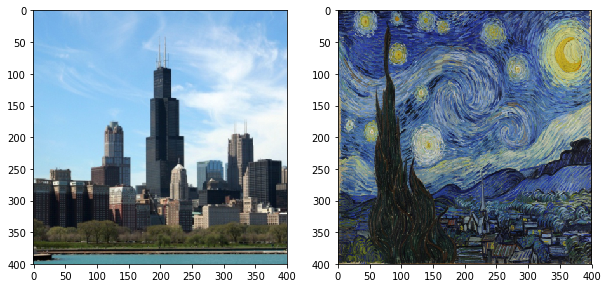

In [5]:
# 可视化两个图像
content = load_image(content_path)
style = load_image(style_path, shape=tuple(content.shape[-2:]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(image_restore(content))
ax2.imshow(image_restore(style))

In [6]:
# 定义风格迁移模型，使用在imagenet上预训练好的vgg16作为基础模型
class StyleTransferModel(paddle.nn.Layer):
    def __init__(self):
        super(StyleTransferModel, self).__init__()
        # pretrained设置为true，会自动下载imagenet上的预训练权重并加载
        vgg = vgg16(pretrained=True)
        self.base_model = vgg.features

        for p in self.base_model.parameters():
            p.stop_gradient = True
        self.layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '17': 'conv4_1',
            '19': 'conv4_2',  ## content representation
            '24': 'conv5_1'
        }

    def forward(self, image):
        outputs = []
        for name, layer in self.base_model.named_sublayers():
            image = layer(image)
            if name in self.layers:
                outputs.append(image)
        return outputs

In [7]:
class StyleTransferLoss(paddle.nn.Layer):
    def __init__(self,
                 content_loss_weight=1,
                 style_loss_weight=1e5,
                 style_weights=[1.0, 0.8, 0.5, 0.3, 0.1]):
        super(StyleTransferLoss, self).__init__()
        self.content_loss_weight = content_loss_weight
        self.style_loss_weight = style_loss_weight
        self.style_weights = style_weights

    def forward(self, *features):
        outputs = features[:6]
        labels = features[6:]
        content_features = labels[-1]
        style_features = labels[:-1]

        # 计算图像内容相似度的loss
        content_loss = paddle.mean((outputs[-2] - content_features)**2)

        # 计算风格相似度的loss
        style_loss = 0
        style_grams = [self.gram_matrix(feat) for feat in style_features]
        style_weights = self.style_weights
        for i, weight in enumerate(style_weights):
            target_gram = self.gram_matrix(outputs[i])
            layer_loss = weight * paddle.mean((target_gram - style_grams[
                i])**2)
            b, d, h, w = outputs[i].shape
            style_loss += layer_loss / (d * h * w)

        total_loss = self.content_loss_weight * content_loss + self.style_loss_weight * style_loss
        return total_loss

    def gram_matrix(self, A):
        if len(A.shape) == 4:
            _, c, h, w = A.shape
            A = paddle.reshape(A, (c, h * w))
        GA = paddle.matmul(A, paddle.transpose(A, [1, 0]))

        return GA

In [8]:
# 创建模型
net = StyleTransferModel()
model = paddle.Model(net)

In [9]:
# 创建损失函数
style_loss = StyleTransferLoss()

In [10]:
# 使用内容图像初始化要生成的图像
target = net.create_parameter(shape=content.shape)
target.set_value(content.numpy())

In [11]:
# 创建优化器
optimizer = paddle.optimizer.Adam(parameters=[target], learning_rate=0.001)

In [12]:
# 初始化高级api
model.prepare(optimizer, style_loss)

In [13]:
# 使用内容图像和风格图像获取内容特征和风格特征
content_fetures = model.predict_batch(content)
style_features = model.predict_batch(style)

In [14]:
# 将两个特征组合，作为损失函数的label传给模型
feats = style_features + [content_fetures[-2]]

iters: 0 loss: [6.025131e+11]


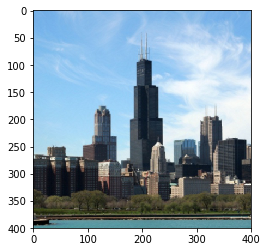

iters: 500 loss: [1.3697012e+10]


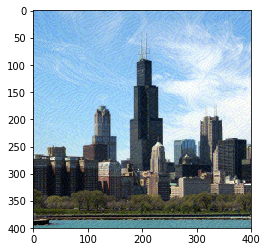

iters: 1000 loss: [6.3677174e+09]


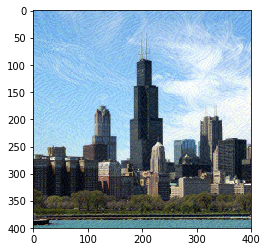

iters: 1500 loss: [3.9739177e+09]


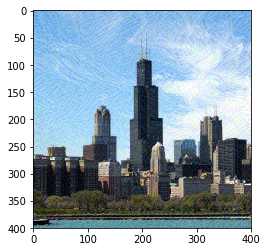

iters: 2000 loss: [2.81457e+09]


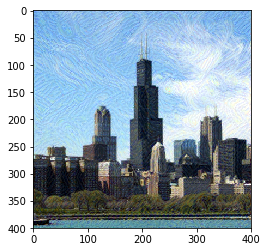

iters: 2500 loss: [2.1521928e+09]


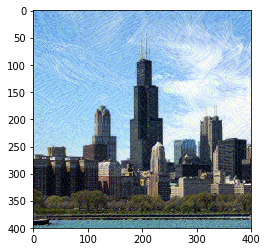

iters: 3000 loss: [1.7276887e+09]


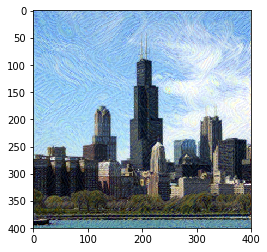

iters: 3500 loss: [1.4331168e+09]


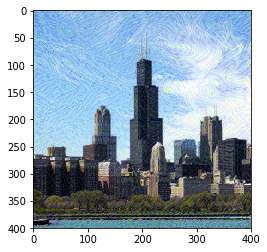

iters: 4000 loss: [1.2144397e+09]


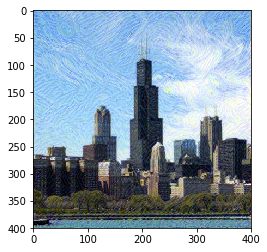

iters: 4500 loss: [1.0442223e+09]


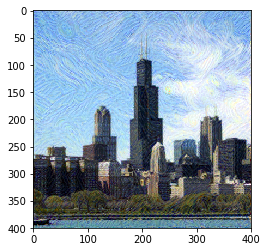

In [15]:
# 训练5000个step，每500个step画一下生成的图像查看效果
steps = 5000
for i in range(steps):
    outs = model.train_batch(target, feats)
    
    if i % 500 == 0:
        print('iters:', i, 'loss:', outs[0])
        plt.imshow(image_restore(target))
        plt.show()

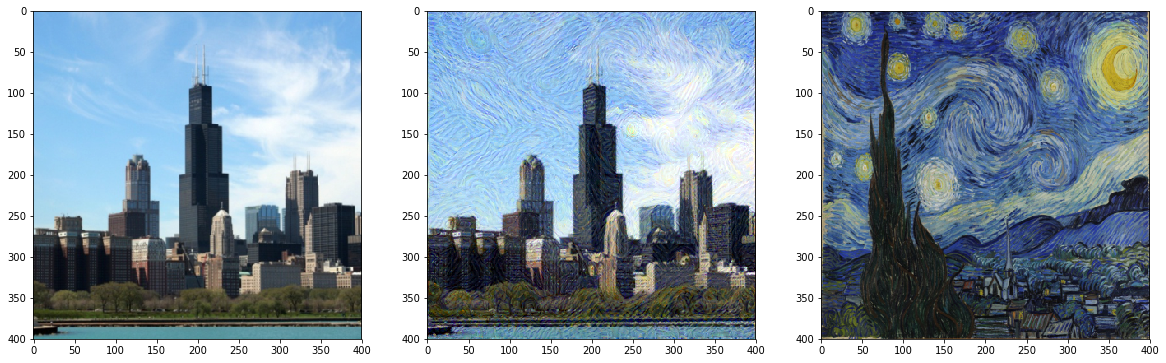

In [16]:
# 风格迁移后的图像
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(image_restore(content))
ax2.imshow(image_restore(target))
ax3.imshow(image_restore(style))